In [127]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import joblib
from sklearn.base import BaseEstimator, TransformerMixin

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

#Función para calcular las métricas
def evaluate_model(model, data, labels):
    predictions = model.predict(data)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    mape = calculate_mape(labels, predictions)
    return rmse, mae, r2, mape

results = []

In [128]:
## EXPLORACIÓN DE LA BASE DE DATOS ##
data = pd.read_csv('final3.csv')
data=data.drop("serial", axis=1)
data=data.drop("labels", axis=1)
data=data.drop("stations", axis=1)

print(data.head())
print("_____________________________________________")
print(data.info())
print("_____________________________________________")
print(data.describe())


     tempmax    tempmin       temp  feelslikemax  feelslikemin  feelslike  \
0  34.053151  24.478082  28.709863     39.757808     25.317808  32.306301   
1  34.086179  25.694309  29.464228     41.338211     28.140650  34.423577   
2  34.573984  25.417886  29.526829     40.464228     26.560163  33.085366   
3  33.020325  25.080488  28.727642     37.878049     26.193496  31.772358   
4  30.660976  24.230894  26.774797     36.586992     24.263415  28.943902   

         dew   humidity     precip  precipprob  ...  windspeed     winddir  \
0  22.971233  73.508219   2.921726   44.657534  ...  15.678356  175.595342   
1  23.484553  72.066667   3.783415   39.837398  ...  14.574797  158.349593   
2  22.580488  69.424390   3.065854   33.333333  ...  14.978049  202.621138   
3  21.752033  69.297561   6.025203   37.398374  ...  16.504878  183.544715   
4  24.214634  86.652033  23.336585   96.747967  ...  19.546341  224.030081   

   sealevelpressure  cloudcover  visibility  solarradiation  solaren

_______________________________________
cases               1.000000
feelslike           0.413687
temp                0.378554
windspeed           0.375570
feelslikemin        0.374987
tempmin             0.366211
feelslikemax        0.302470
tempmax             0.284023
visibility          0.249682
dew                 0.179842
winddir             0.028523
precip             -0.012720
sealevelpressure   -0.016517
cloudcover         -0.192663
humidity           -0.211555
precipprob         -0.218753
solarradiation     -0.219238
solarenergy        -0.220682
uvindex            -0.228829
precipcover        -0.235214
conditions         -0.437674
snow                     NaN
snowdepth                NaN
Name: cases, dtype: float64
_______________________________________
Skewness of the 'cases' column: 0.5944160600674353


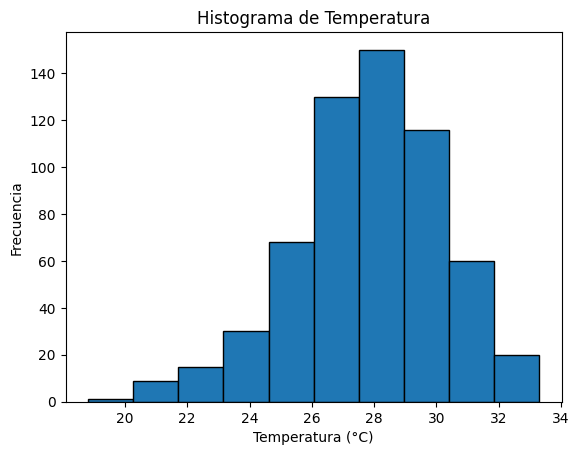

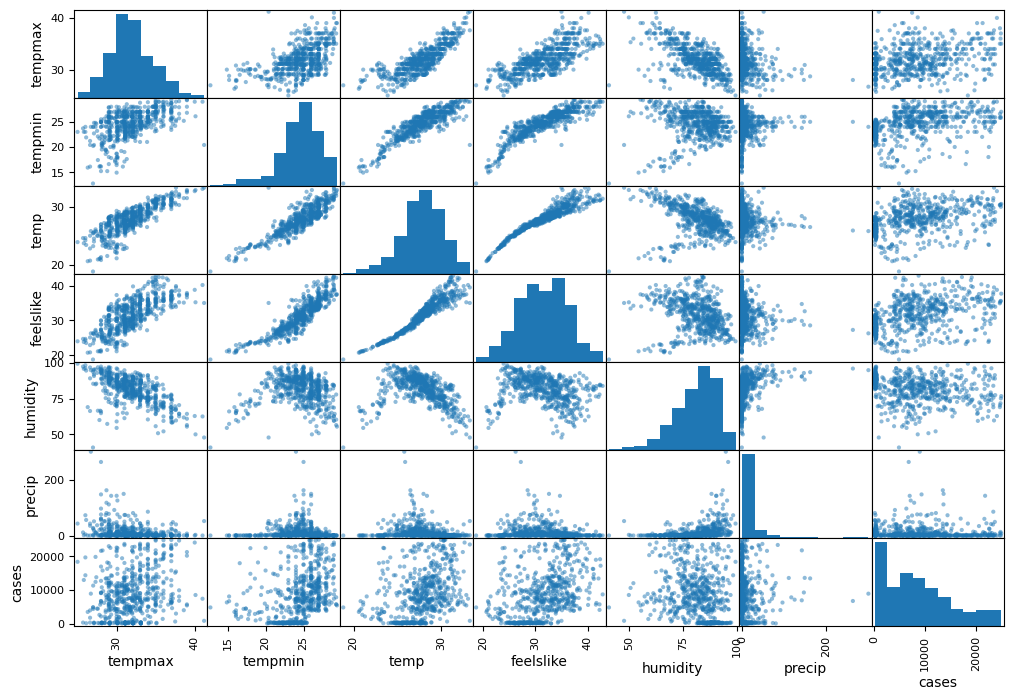

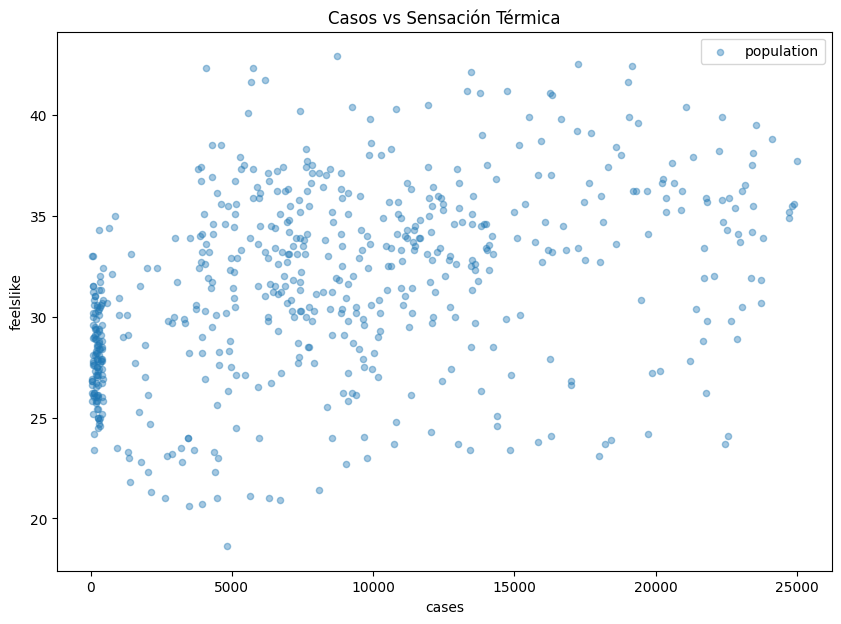

In [129]:
## VISUALIZACIÓN DE DATOS ##

# Diagrama de Caja
fig = px.box(data, x='cases', title='Diagrama de Caja')
fig.show()

# Gráfica de Barras
fig = plt.hist(data['temp'], bins=10, edgecolor='black')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frecuencia')
plt.title('Histograma de Temperatura')

# Correlaciones
attributes = ["tempmax", "tempmin","temp", "feelslike", "humidity", "precip", "cases"]
scatter_matrix(data[attributes], figsize=(12, 8))

corr_matrix = data.corr()
print("_______________________________________")
print(corr_matrix["cases"].sort_values(ascending=False))
print("_______________________________________")

data.plot(kind="scatter", x='cases', y='feelslike', title='Casos vs Sensación Térmica', alpha=0.4, label="population", figsize=(10,7))
plt.legend()

skewness = data['cases'].skew()
print(f"Skewness of the 'cases' column: {skewness}")

In [130]:
## PREPARACIÓN Y DIVISIÓN DE LOS DATOS ##
#Dividir los datos en high y low cases basandose en el percentil 75
high_cases = data[data['cases'] > data['cases'].quantile(0.65)]
low_cases = data[data['cases'] <= data['cases'].quantile(0.65)]
# Downsample
low_cases_downsampled = low_cases.sample(len(high_cases), replace=True)
# Oversample
high_cases_oversampled = high_cases.sample(len(low_cases), replace=True)
# Combinar
data = pd.concat([low_cases_downsampled, high_cases_oversampled])
# Diagrama de Caja
fig = px.box(data, x='cases', title='Diagrama de Caja')
fig.show()

data_labels = data["cases"].copy()
data = data.drop("cases", axis=1) #Separar las etiquetas
print(data_labels)

#Custom Transformers
#Añade nuevos atributos a partir de la combinación de otros ya existentes
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_temp_humidity=True, add_temp_precip=True, add_temp_squared=True):
        self.add_temp_humidity = add_temp_humidity
        self.add_temp_precip = add_temp_precip
        self.add_temp_squared = add_temp_squared

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_temp = X.copy()

        if self.add_temp_humidity:
            X_temp['temp_humidity'] = X_temp['temp'] * X_temp['humidity']

        if self.add_temp_precip:
            X_temp['temp_precip'] = X_temp['temp'] * X_temp['precip']

        if self.add_temp_squared:
            X_temp['temp_squared'] = X_temp['temp'] ** 2

        return X_temp

full_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()), #Se aplica el nuevo atributo
    ('scaler', StandardScaler())#,  #Se escala
   # ('pca', PCA(n_components=0.99))  #Se aplica PCA
])
# Guardar pipeline
joblib.dump(full_pipeline, 'pipeline.joblib')
pipeline_loaded = joblib.load('pipeline.joblib')

data_prepared = full_pipeline.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_labels, test_size=0.20, random_state=42)

340    10252
86      4938
502     4036
518     6543
427     6691
       ...  
324    21781
297    13024
400    20379
492    12132
378    22229
Name: cases, Length: 599, dtype: int64


Best parameters for polinomial kernel:  {'C': 50, 'coef0': 2, 'degree': 6, 'kernel': 'poly'}
              Model         RMSE          MAE        R²       MAPE
0  SVR (polinomial)  4411.970331  2746.170693  0.610954  152.43711


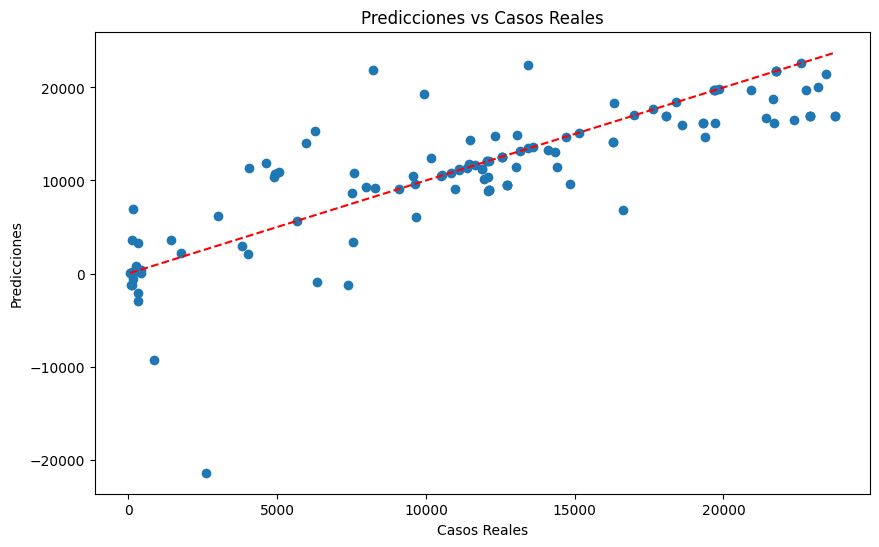

In [131]:
# 1. Algoritmos SVM #
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Modelo polinomial ##
param_grid_poli = {
    'C': [ 10,20,30, 45,50],
    'kernel': ['poly'],
    'degree': [2, 3,5,6,4],
    'coef0': [0.5, 1, 1.5, 2],
}
grid_search_poli = GridSearchCV(SVR(), param_grid_poli, scoring='neg_mean_absolute_percentage_error',cv=kf)
grid_search_poli.fit(X_train, y_train)
print("Best parameters for polinomial kernel: ", grid_search_poli.best_params_)

# Evaluación del modelo
psvr_rmse, psvr_mae, psvr_r2, psvr_mape = evaluate_model(grid_search_poli.best_estimator_, X_test, y_test)
results.append({"Model": "SVR (polinomial)", "RMSE": psvr_rmse, "MAE": psvr_mae, "R²": psvr_r2, "MAPE": psvr_mape})
#Mostrar los resultados
results_df = pd.DataFrame(results)
print(results_df)

# Visualización de predicciones
predictions_poli = grid_search_poli.best_estimator_.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_poli)
plt.xlabel('Casos Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Casos Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Línea de referencia
plt.show()

#Save model
joblib.dump(grid_search_poli, "poli.pkl")
poli_loaded = joblib.load("poli.pkl")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
              Model         RMSE          MAE        R²        MAPE
0  SVR (polinomial)  4411.970331  2746.170693  0.610954  152.437110
1     Decision Tree  3496.900951  1629.458333  0.755599   84.627632


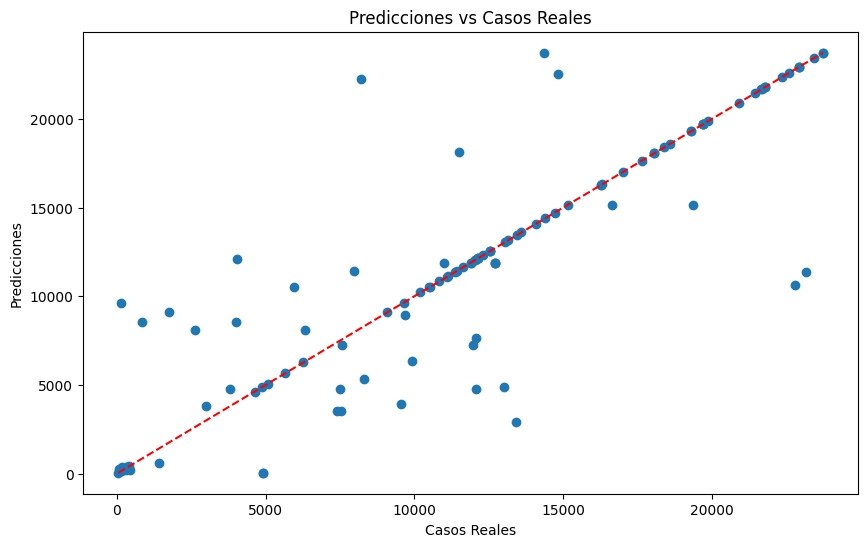

In [133]:
# 2. Decision Tree #
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
# 5. Entrenamiento del modelo Decision tree
tree = DecisionTreeRegressor(random_state=42)

param_grid_tree = {
    'max_depth': [None,4,5,10,20],  # Profundidad máxima del árbol
    'min_samples_split': [2,5,10],     # Mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1,2,10,20],     # Mínimo de muestras en un nodo hoja
    'max_features': [None, 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
}

grid_search_tree = GridSearchCV(estimator=tree, param_grid=param_grid_tree, scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1, verbose=2)
grid_search_tree.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
best_tree = grid_search_tree.best_estimator_
predictions_tree = best_tree.predict(X_test)

# Evaluación del modelo
tree_rmse, tree_mae, tree_r2, tree_mape = evaluate_model(grid_search_tree.best_estimator_, X_test, y_test)
results.append({"Model": "Decision Tree", "RMSE": tree_rmse, "MAE": tree_mae, "R²": tree_r2, "MAPE": tree_mape})
#Mostrar los resultados
results_df = pd.DataFrame(results)
print(results_df)

# Visualización de predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_tree)
plt.xlabel('Casos Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Casos Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Línea de referencia
plt.show()

#Save model
joblib.dump(best_tree, "tree.pkl")
tree_loaded = joblib.load("tree.pkl")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
              Model         RMSE          MAE        R²        MAPE
0  SVR (polinomial)  4411.970331  2746.170693  0.610954  152.437110
1     Decision Tree  3496.900951  1629.458333  0.755599   84.627632
2     Random Forest  2956.950591  1964.935318  0.825247   65.737259


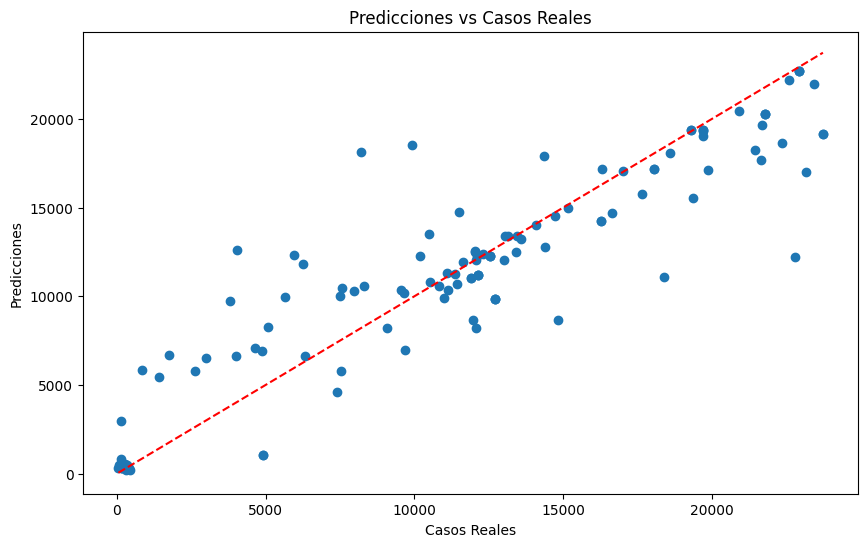

In [134]:
# 3. Random Forest #
model = RandomForestRegressor(random_state=42)

'''param_grid = {
    'n_estimators': [200, 300, 500, 1000],
    'max_features': [None, 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
}
'''
param_grid = {
    'n_estimators': [200],
    'max_features': [ 'sqrt', None],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [2, 3],
}

# Configurar GridSearchCV
grid_search_forest = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_absolute_percentage_error',
                           cv=5, n_jobs=-1, verbose=2)
grid_search_forest.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
best_model_forest = grid_search_forest.best_estimator_
predictions_forest = best_model_forest.predict(X_test)

# Evaluación del modelo
print("Best parameters found: ", grid_search_forest.best_params_)
forest_rmse, forest_mae, forest_r2, forest_mape = evaluate_model(grid_search_forest.best_estimator_, X_test, y_test)
results.append({"Model": "Random Forest", "RMSE": forest_rmse, "MAE": forest_mae, "R²": forest_r2, "MAPE": forest_mape})
#Mostrar los resultados
results_df = pd.DataFrame(results)
print(results_df)

# Visualización de predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_forest)
plt.xlabel('Casos Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Casos Reales')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Línea de referencia
plt.show()

#Save model
joblib.dump(best_model_forest, "forest.pkl")
forest_loaded = joblib.load("forest.pkl")


               Model         RMSE          MAE        R²        MAPE
0   SVR (polinomial)  4411.970331  2746.170693  0.610954  152.437110
1      Decision Tree  3496.900951  1629.458333  0.755599   84.627632
2      Random Forest  2956.950591  1964.935318  0.825247   65.737259
3  Voting Regressor:  1648.320936  1103.754061  0.945698   87.598683


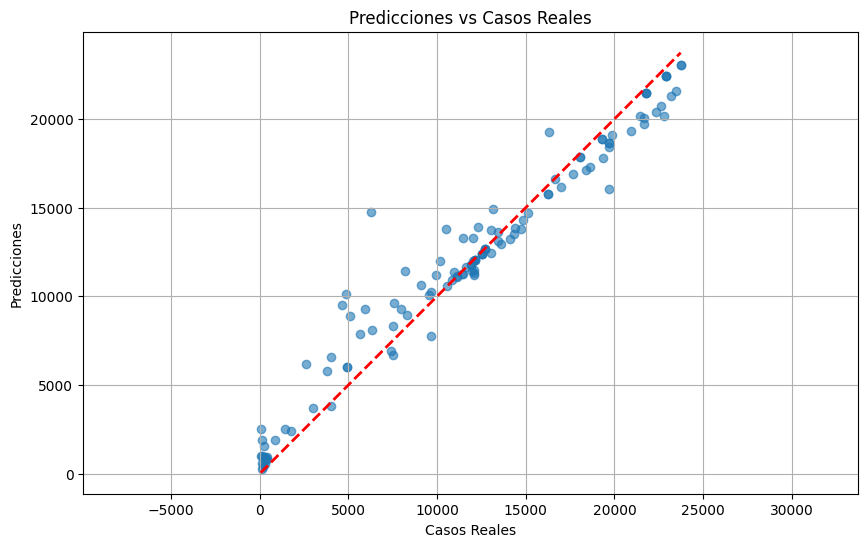

In [135]:
# 4. Ensambles #
 # a) Voting
forest_reg = best_model_forest
svm_reg = grid_search_poli.best_estimator_
best_tree = best_tree

voting_reg = VotingRegressor(
    estimators=[('rf', forest_reg), ('svr', grid_search_poli.best_estimator_)],
    weights=[0.6,0.4]
)
voting_reg.fit(X_test, y_test)
y_pred=voting_reg.predict(X_test)
# Evaluación del modelo
voting_rmse, voting_mae, voting_r2, voting_mape = evaluate_model(voting_reg, X_test, y_test)
results.append({"Model": "Voting Regressor:", "RMSE": voting_rmse, "MAE": voting_mae, "R²": voting_r2, "MAPE": voting_mape})
#Mostrar los resultados
results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, linestyle='--')  # Línea de referencia
plt.xlabel('Casos Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Casos Reales')
plt.axis('equal')
plt.grid()
plt.show()

#Save model
joblib.dump(voting_reg, "voting.pkl")
voting_loaded = joblib.load("voting.pkl")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest - Accuracy: 0.9669421487603306
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.93        29
           1       0.96      1.00      0.98        92

    accuracy                           0.97       121
   macro avg       0.98      0.93      0.95       121
weighted avg       0.97      0.97      0.97       121



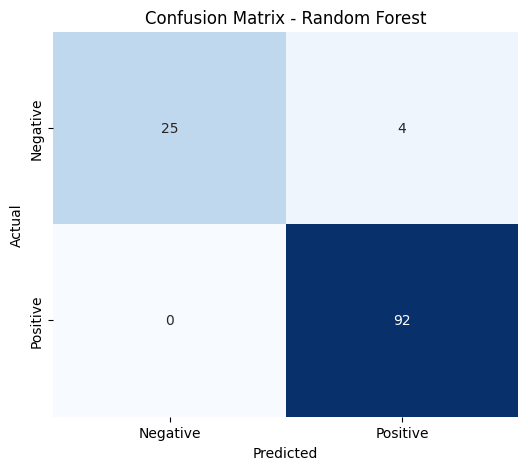

['rf_class.pkl']

In [136]:
#5. Clasificación de Outbreak
data = pd.read_csv('final.csv')
data = data.drop(["serial", "labels"], axis=1)
data=data.drop("stations", axis=1)

# Crear categoría de casos
bins = [0, 2000, float('inf')]
labels = [0, 1]
data['cases_category'] = pd.cut(data['cases'], bins=bins, labels=labels)

data_labels = data["cases_category"]
data = data.drop(["cases_category", "cases"], axis=1)  # Remove target and 'cases'

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_temp_humidity=True, add_temp_precip=True, add_temp_squared=True):
        self.add_temp_humidity = add_temp_humidity
        self.add_temp_precip = add_temp_precip
        self.add_temp_squared = add_temp_squared

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_temp = X.copy()

        if self.add_temp_humidity:
            X_temp['temp_humidity'] = X_temp['temp'] * X_temp['humidity']

        if self.add_temp_precip:
            X_temp['temp_precip'] = X_temp['temp'] * X_temp['precip']

        if self.add_temp_squared:
            X_temp['temp_squared'] = X_temp['temp'] ** 2

        return X_temp

full_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),  # Nuevos atributos
    ('scaler', StandardScaler()),  # Escalado
])

# Aplicar pipeline
data_prepared = full_pipeline.fit_transform(data)
# Guardar pipeline
joblib.dump(full_pipeline, 'pipeline_classification.joblib')
pipeline_loaded = joblib.load('pipeline_classification.joblib')

# Dividir datos
X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size=0.2, random_state=42)
X_resampled, y_resampled = X_train, y_train

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(rf_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_resampled, y_resampled)

# Evaluación del modelo
print("Best parameters found: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict((X_val))
print("Best Random Forest - Accuracy:", accuracy_score(y_val, y_pred_best_rf))
print("Classification Report:\n", classification_report(y_val, y_pred_best_rf))

# Crear Matriz de Confusión
cm = confusion_matrix(y_val, y_pred_best_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Save the best model
joblib.dump(best_rf_model, "rf_class.pkl")


#Conclusiones
Se logró programar un modelo de regresión que considero funcional para el objetivo que tiene: Predecir el número de casos de dengue basándose en los factores climáticos de una región dada.

| Model | RMSE| MAE | R2 | MAPE|
|-----------|-----------|-------|----|---|
|SVR| 4411.970331  |2746.170 | 0.61 | 152.437|
| Decision Tree    |3496.9 | 1629.45 | 0.755 |  84.627|
|Random Forest    |2956.95|  1964.93 | 0.825|  65.737|
|Voting Regressor|1648.32|1103.7|0.945| 87.59|

Como se puede ver en los resultados, el modelo de Voting Regressor fue el que obtuvo una mejor puntuación de R2, MAE y RMSE, lo cual no considero sorprendente, ya que es bien sabido que ese tipo de ensambles permiten la disminución de los errores específicos de cada modelo utilizado en la construcción del mismo (SVR, DT y RF).
Considero que un rango de error absoluto de 1100 es completamente aceptable si estamos hablando de una escala de 25000 casos, y tomando en cuenta la base de datos utilizada, estoy satisfecho con los resultados.

Además se realizó la creación del modelo de clasificación, en la que sólo se tienen dos clases: Brote de dengue y Ausencia de brote de dengue. En este caso se obtuvo una precisión del 96.69% además de un F1 Score medio del 95%, el cual supera al de las investigaciones pasadas, por lo cual también lo considero como un éxito.